In [2]:
import pandas as pd
import numpy as np
import torch
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import EarlyStoppingCallback
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import yaml
from transformers import AdamW, BertConfig
import util
import warnings


In [3]:
seed_val = 20

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [4]:
settings = util.parse_settings()
warnings.filterwarnings("ignore", category =UserWarning)

In [5]:
settings

{'email': 'bowen806@hotmail.com',
 'pwd': None,
 'text': 'text',
 'order': 'IBES_Timestamp',
 'target': 'BHAR_0_30',
 'rolling': 3,
 'train_ratio': 0.8,
 'EN_param': {'tol': 1e-05, 'l1_ratio': [0.1, 0.2, 0.4, 0.6, 0.8, 1]},
 'SVM_param': {'tol': 0.0001, 'C': [0.01, 0.5, 1, 1.5]},
 'bert_model': 'bert-base-uncased',
 'parquet': 'C:/Users/Steve/Projects/ML Earnings/Data/IBES_CRSP_Merged_PR_2003_2019_v02.parquet'}

In [6]:
df = pd.read_parquet(settings['parquet'])
df.head(5)

,date,permno,GVKEY,CNAME,IBES_Timestamp,IBES_Actual_Date,Year,Quarter,rdq,SUE_Med,...,cik,filename,text,text_no_sw,text_stemmed,text_short,text_no_sw_lr_sent,text_short_lr_sent,text_no_sw_pr_sent,text_short_pr_sent
0,2003-01-03,19502,11264,WALGREEN CO,2003-01-03 08:55:00,2003-01-03,2003,1,2003-01-03,0.000346,...,1618921,None,None,None,None,None,NaN,NaN,NaN,NaN
1,2003-01-03,79255,28524,DELTA & PINE LND,2003-01-03 08:09:00,2003-01-03,2003,1,2003-01-03,-0.003868,...,902277,None,None,None,None,None,NaN,NaN,NaN,NaN
2,2003-01-07,69796,2710,CONSTELLAT BRAN,2003-01-06 16:31:00,2003-01-06,2003,1,2003-01-06,0.000213,...,16918,None,None,None,None,None,NaN,NaN,NaN,NaN
3,2003-01-07,76568,23697,SONIC CORP,2003-01-06 17:56:00,2003-01-06,2003,1,2003-01-06,0.000000,...,868611,None,None,None,None,None,NaN,NaN,NaN,NaN
4,2003-01-07,86822,119574,EXTREME NETWKS,2003-01-06 16:44:00,2003-01-06,2003,1,2003-01-06,-0.003003,...,1078271,86822_20030106_0.html,dated january extreme networks reports q fy fi...,dated january extreme networks reports financi...,date januari extrem network report financi res...,dated january extreme networks reports q fy fi...,0.012987,-0.01,0.01039,0.01


(<AxesSubplot:>, 9.552693305778213, -0.9813644383200316)

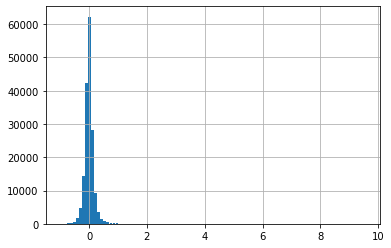

In [7]:
df.BHAR_0_30.hist(bins=100, rwidth =0.9), df['BHAR_0_30'].max(),df['BHAR_0_30'].min()

In [8]:
def rolling_batch(df,tokens,tokenizer, start, roll = 3):
    tr_target = df[df['Year']>=start][df['Year']<start+roll][settings['target']]
    t_target = df[df['Year']==start+roll][settings['target']]
    slice_tr, slice_t = len(tr_target),len(t_target)
    tr_tokens, t_tokens = tokenizer(" "),tokenizer(" ")
    tr_tokens['input_ids'] = tokens['input_ids'][:slice_tr]
    tr_tokens['attention_mask'] = tokens['attention_mask'][:slice_tr]
    t_tokens['input_ids'] = tokens['input_ids'][slice_tr:slice_tr+slice_t]
    t_tokens['attention_mask'] = tokens['attention_mask'][slice_tr:slice_tr+slice_t]
    return tr_tokens, tr_target, t_tokens, t_target

In [9]:
df = df.sort_values(by = settings['order'], ascending=True)
df = df[df[settings["text"]].notnull()][df[settings["target"]].notnull()]
print(len(df))
model_name = "IBES_CRSP_PR_RW"
bertModel = settings['bert_model']
tokenizer = BertTokenizerFast.from_pretrained(bertModel)
df[settings["text"]] = df[settings["text"]].apply(util.limit_words)
target = df[settings["target"]]


142003


In [10]:
def tokenize(text, tokenizer, max_len, dir, token_name): ##TODO: make config input
    import os
    try:
        os.makedirs(dir)
    except OSError:
        pass
    if(os.path.exists(dir+token_name+"input_id.pt") and os.path.exists(dir+token_name+"attention_mask.pt")):
        input_tokenized = tokenizer("")
        input_tokenized['input_ids'] = torch.load(dir+token_name+"input_id.pt")
        input_tokenized['attention_mask'] = torch.load(dir+token_name+"attention_mask.pt")
    else: 
        input_tokenized = tokenizer(text, add_special_tokens = True, padding='max_length',\
             truncation=True, max_length=max_len, return_tensors='pt')
        torch.save(input_tokenized['input_ids'],dir+token_name+"input_id.pt")
        torch.save(input_tokenized['attention_mask'],dir+token_name+"attention_mask.pt")
    return input_tokenized

In [11]:
ds_name = settings['parquet'].split('/')[-1].split('.')[0]

tokens = tokenize(df[settings["text"]].values.tolist(), tokenizer, max_len=200, dir="./Bert_token_Archive/", token_name=ds_name+"_BertFast_200")

In [12]:
# input_tokenized['input_ids'][32]
# # torch.unique(input_tokenized['attention_mask'])
# # tmp = (input_tokenized['attention_mask']==0).nonzero()
# # tmp.shape
# # torch.min(tmp,0)
# # tmp[8470]

In [13]:
def data_split(input_tokenized,target, split, batch_size = 16):
    input_ids = input_tokenized['input_ids']
    attention_mask = input_tokenized['attention_mask']
    if split == 0:
        labels = torch.Tensor(target).type(torch.FloatTensor)
        data = TensorDataset(input_ids, attention_mask, labels)
        sampler = SequentialSampler(data)
        dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
        return dataloader, None
    else:
        train_inputs, val_inputs, y_train, y_val = train_test_split(input_ids, target, random_state=13, test_size=split) 
        train_masks, val_masks, y_train, y_val = train_test_split(attention_mask, target, random_state=13, test_size=split) 

        # set(y)
        # print('example train_input:', train_inputs[0])
        # print('example attention_mask', train_masks[0])
        train_labels = torch.tensor(y_train).type(torch.FloatTensor)
        validation_labels = torch.tensor(y_val).type(torch.FloatTensor)
        #print(train_labels)
        # Create the DataLoader for our training set.
        train_data = TensorDataset(train_inputs, train_masks, train_labels)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
        # Create the DataLoader for our validation set.
        validation_data = TensorDataset(val_inputs, val_masks, validation_labels)
        validation_sampler = SequentialSampler(validation_data)
        validation_dataloader = DataLoader(validation_data, shuffle=validation_sampler, batch_size=batch_size)

    return train_dataloader, validation_dataloader

In [14]:
# bert_train_dataloader, bert_validation_dataloader,bert_test_dataloader = data_split(input_tokenized,y, split,1)

In [15]:
class BertRegressor_MLP(BertForSequenceClassification):
    def __init__(self, config):
        super(BertRegressor_MLP, self).__init__(config)

        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, config.num_labels),
            )
        # self.epoch = 0
        # self.model_name = model_name
        # self.dataset = dataset
        # self.path = path

In [28]:
from transformers import AdamW, BertConfig

model_freeze_bert = BertRegressor_MLP.from_pretrained(
    "bert-base-uncased", 
    num_labels = 1, 
    output_attentions = False, 
    output_hidden_states = False,
)
for name, param in model_freeze_bert.named_parameters():
	if 'classifier' not in name: 
		param.requires_grad = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertRegressor_MLP: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertRegressor_MLP from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertRegressor_MLP from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertRegressor_MLP were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['

In [17]:
model_finetune_bert = BertRegressor_MLP.from_pretrained(
    "bert-base-uncased", 
    num_labels = 1,    
    output_attentions = False, 
    output_hidden_states = False,
)
# (model_name = "FT_Bert",
#     dataset = ds_name,
#     path = "RW_saves/Bert_FT_Models/")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertRegressor_MLP: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertRegressor_MLP from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertRegressor_MLP from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertRegressor_MLP were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['

In [18]:
def evaluation(model, dataloader,target, device="cuda"):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    predict = []
    model.eval()
    model.to(device)
    for batch in dataloader:
            #batch = tuple(t.to(device) for t in batch)
            batch = tuple(t for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            #b_labels = batch[2]
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            with torch.no_grad():        
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask)
            logits = outputs[0]
            logits = logits.to('cpu').tolist()
            predict+=logits
    r2, mse, mae = r2_score(target, predict), mean_absolute_error(target, predict), mean_squared_error(target, predict)
    return predict, r2, mse, mae

In [32]:
import time
from transformers import get_linear_schedule_with_warmup,get_cosine_with_hard_restarts_schedule_with_warmup
import datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))
    
def predict(model, dataloader, device):
    model.eval()
    model.to(device)
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += [{'pred':model(batch_inputs, 
                            batch_masks)[0].view(-1), 'label': batch_labels}]
    return output

def train_model(model, tokens, epochs, w_start, device, stats, model_name):     
    ## how to feed data
    tr_tokens, tr_target, t_tokens, t_target = rolling_batch(df, tokens, tokenizer, w_start)
    tr_target =tr_target.values
    t_target =t_target.values
    train_dataloader, validation_dataloader = data_split(tr_tokens, tr_target, 0.2, batch_size=10)
    optimizer = AdamW(model.parameters(),
                  lr = 1e-3, 
                  eps = 1e-8 
                )
    total_steps = len(train_dataloader) * epochs
    # scheduler = get_linear_schedule_with_warmup(optimizer, 
    #                                         num_warmup_steps = 10, 
    #                                         num_training_steps = total_steps)
    scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 10, 
                                            num_training_steps = total_steps,
                                            num_cycles = total_steps/100)
    loss_values = []
    eval_accs = []
    model = model.to(device)
    for epoch_i in range(0, epochs):
        #model.epoch+=1
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        t0 = time.time()
        total_loss = 0
        model.train()

        for step, batch in enumerate(train_dataloader):

            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # This will return the loss (rather than the model output) because we
            # have provided the `labels`.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
            
            # The call to `model` always returns a tuple, so we need to pull the 
            # loss value out of the tuple.
            loss = outputs[0]
            #print(outputs)
            # print("train set")
            # for i in range(outputs[1].shape[0]):
            #     print(outputs[1][i], b_labels[i])
            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)            
        
        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.8f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
            

        print("Running Validation...")

        t0 = time.time()
        model.eval()

        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            # batch = tuple(t for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have
                # not provided labels.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask)
            
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            logits = outputs[0]
            
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # print(logits, label_ids)
            # Calculate the accuracy for this batch of test sentences.
            # for i in range(logits.shape[0]):
            #     print(logits[i], label_ids[i])
            tmp_eval_loss = mean_squared_error(logits, label_ids)
            # Accumulate the total accuracy.
            eval_loss += tmp_eval_loss
            # Track the number of batches
            nb_eval_steps += 1

        avg_eval_acc = eval_loss/nb_eval_steps
        print("  Loss: {0:.8f}".format(avg_eval_acc))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))
        eval_accs.append(avg_eval_acc)
    print("")
    print("Training complete!")
    try:
        import os
        os.mkdir("RW_saves_v2/Bert_{}_Models/".format(model_name))
    except OSError:
        pass
    model.save_pretrained("RW_saves_v2/Bert_{}_Models/".format(model_name)+"PR_v2_200/"+str(w_start)+"/")
    in_dataloader,_ = data_split(tr_tokens, tr_target, 0)
    out_dataloader,_ = data_split(t_tokens, t_target, 0)
    i_pred, r2, mse, mae = evaluation(model, in_dataloader, tr_target, device="cuda")
    o_pred,o_r2, o_mse, o_mae = evaluation(model, out_dataloader, t_target, device="cuda")
    # print(i_pred, o_pred, r2, mse, mae, o_r2, o_mse, o_mae)
    stats[w_start] = {'r2': r2, 'mse':mse, 'mae':mae, 'o_r2': o_r2, 'o_mse':o_mse, 'o_mae':o_mae}
    
    
    return model, loss_values, eval_accs, i_pred, o_pred, stats

In [ ]:
# tr_tokens, tr_target, t_tokens, t_target = rolling_batch(df, tokens, tokenizer, 2003)
# in_dataloader,_ = data_split(tr_tokens, tr_target.values, 0)
# out_dataloader,_ = data_split(t_tokens, t_target.values, 0)
# i_pred, r2, mse, mae = evaluation(model_finetune_bert, in_dataloader, tr_target, device="cuda")
# o_pred,o_r2, o_mse, o_mae = evaluation(model_finetune_bert, out_dataloader, t_target, device="cuda")
# print(i_pred, o_pred, r2, mse, mae, o_r2, o_mse, o_mae)

21625

In [25]:
stats = {}


In [26]:
CONTINUE_TRAIN = False
model_path = "./RW_saves_v2/Bert_FT_Models/"+"PR_v2_200/"+str(2003)+"/"
if CONTINUE_TRAIN and os.path.exists(model_path):
    model_finetune_bert.load_state_dict(torch.load(model_path+"pytorch_model.bin"))
    print("Model reload!")


Model reload!


In [34]:
model_finetune_bert, loss_values, eval_accs, i_pred, o_pred, stats = train_model(model_finetune_bert, tokens, 100, 2003, "cuda", stats, "FZ")
with open("RW_Bert_stats.json", 'w') as f:
    import json
    json.dump(stats, f)



======== Epoch 1 / 100 ========
Training...
  Batch    40  of  1,730.    Elapsed: 0:00:04.
  Batch    80  of  1,730.    Elapsed: 0:00:08.
  Batch   120  of  1,730.    Elapsed: 0:00:12.
  Batch   160  of  1,730.    Elapsed: 0:00:16.
  Batch   200  of  1,730.    Elapsed: 0:00:20.
  Batch   240  of  1,730.    Elapsed: 0:00:25.
  Batch   280  of  1,730.    Elapsed: 0:00:29.
  Batch   320  of  1,730.    Elapsed: 0:00:33.
  Batch   360  of  1,730.    Elapsed: 0:00:37.
  Batch   400  of  1,730.    Elapsed: 0:00:41.
  Batch   440  of  1,730.    Elapsed: 0:00:45.
  Batch   480  of  1,730.    Elapsed: 0:00:49.
  Batch   520  of  1,730.    Elapsed: 0:00:53.
  Batch   560  of  1,730.    Elapsed: 0:00:57.
  Batch   600  of  1,730.    Elapsed: 0:01:02.
  Batch   640  of  1,730.    Elapsed: 0:01:06.
  Batch   680  of  1,730.    Elapsed: 0:01:10.
  Batch   720  of  1,730.    Elapsed: 0:01:14.
  Batch   760  of  1,730.    Elapsed: 0:01:18.
  Batch   800  of  1,730.    Elapsed: 0:01:22.
  Batch   840  

In [24]:
torch.cuda.empty_cache()
torch.cuda.memory_summary()
import gc
gc.collect()


128

In [25]:
type(y[0])

numpy.float64

In [26]:
fine_bert_loss_vals, fine_bert_eval_accs = train_model(model_freeze_bert, 300, 
                                    bert_train_dataloader,
                                    bert_validation_dataloader, 'cuda') 

AssertionError: Torch not compiled with CUDA enabled